<h1> Data Scientist Take-Home Exercise - BMC - CRISP DM Framework</h1>

# STEP1 : Business Understanding

## Problem Statement:  
Your Marketing department would like to contextualize companies website to show viable products your customers might purchase based on past orders/transactions. To help with this effort, the Marketing department contacted you to build an ML model. Analyze the provided dataset and build a predictive model to predict the probability that a given customer will buy a "printer-related product." To achieve the following  
• Share your findings with the marketing team (non-technical or Business stakeholders)  
• Build a production-ready ML Model for deployment  

## Data Dictionary:    
1. customer_info  
2. product_info  
3. customer_transaction_info  
4. orders_returned_info  
5. region_seller_info  
"printer-related product" can be identified if a customer has ordered a product if the Product Name field contains the word “printer" and the product sub-category is 'Machines.'  

## Importing Required libraries:

In [1]:
# Imports :
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm#_notebook as tqdm
import yaml

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, recall_score
import pickle

from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import os, sys, json

# suppress warnings :
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
# Display 50 columns in the joined DataFrame
pd.set_option('display.max_columns', 50)

## Defining the target feature:
"printer-related product" can be identified if a customer has ordered a product if the Product Name field contains the word “printer" and the product sub-category is 'Machines.'

# STEP2: Data Understanding:

## Loading the data :  
The json files have different structures and few of them have nested structure, so reading them separately.

In [3]:
# Get the current working directory
current_path = os.getcwd()

# Append the desired directory name
bmc_data_path = os.path.join(current_path, 'bmc_data')

# Optionally, if you want to create the directory if it doesn't exist
if not os.path.exists(bmc_data_path):
    os.makedirs(bmc_data_path)

## df_product_info:

In [4]:
# Read the JSON data from 'product_info.json' with explicit encoding
file_path = os.path.join(bmc_data_path, 'product_info.json')
with open(file_path, 'r', encoding='utf-8') as file:
    json_data = json.load(file)

# Extract the fields and data from the JSON
fields = json_data['schema']['fields']
product_data = json_data['data']

# Create a DataFrame from the product_data list
df_product_info = pd.DataFrame(product_data)

# Set the column names based on the 'name' field in the schema
df_product_info.columns = [field['name'] for field in fields]

# Print the DataFrame to see the result
df_product_info.head()

,index,Product ID,Category,Sub-Category,Product Name
0,0,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase
1,1,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,..."
2,2,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...
3,3,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table
4,4,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System


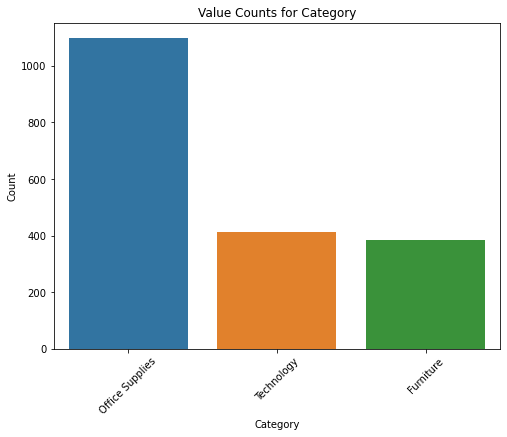

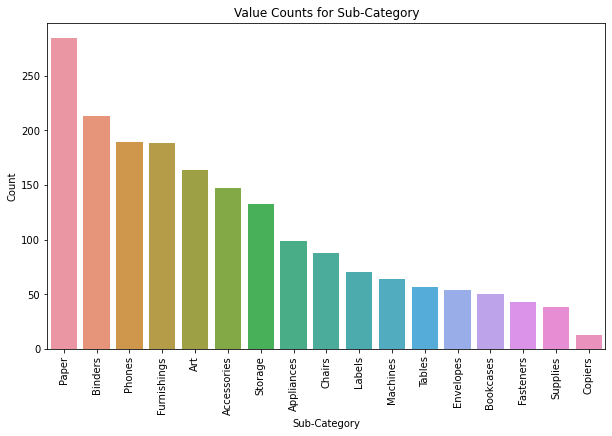

In [5]:
# Plot value counts for 'Category'
plt.figure(figsize=(8, 6))
sns.countplot(data=df_product_info, x='Category', order=df_product_info['Category'].value_counts().index)
plt.title('Value Counts for Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Plot value counts for 'Sub-Category'
plt.figure(figsize=(10, 6))
sns.countplot(data=df_product_info, x='Sub-Category', order=df_product_info['Sub-Category'].value_counts().index)
plt.title('Value Counts for Sub-Category')
plt.xlabel('Sub-Category')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

**Office Supplies is the highest category whereas Paper, Blinders and Phones are top-3 sub-category of products**

### Create target column printer_related:

In [6]:
df_product_info['printer_related'] = (
    (df_product_info['Product Name'].str.contains("printer", case=False))
    & (df_product_info['Sub-Category'] == "Machines")
)

In [7]:
df_product_info.head()

,index,Product ID,Category,Sub-Category,Product Name,printer_related
0,0,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,False
1,1,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",False
2,2,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,False
3,3,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,False
4,4,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,False


In [8]:
# Assuming df_product_info is the DataFrame containing the data you provided
df_product_info.drop('index', axis=1, inplace=True)

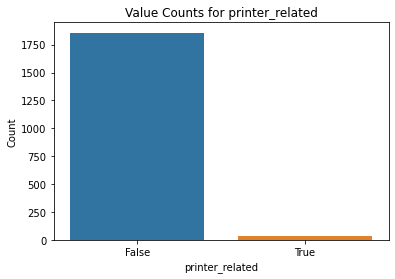

In [9]:

# Plot value counts for 'printer_related'
plt.figure(figsize=(6, 4))
sns.countplot(data=df_product_info, x='printer_related')
plt.title('Value Counts for printer_related')
plt.xlabel('printer_related')
plt.ylabel('Count')
plt.show()

In [10]:
df_product_info.shape

(1894, 5)

In [11]:
df_product_info.nunique()

Product ID         1862
Category              3
Sub-Category         17
Product Name       1850
printer_related       2
dtype: int64

In [12]:
df_product_info['printer_related'].value_counts()

False    1856
True       38
Name: printer_related, dtype: int64

**Only 2% products are printer related**

In [13]:
df_product_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1894 entries, 0 to 1893
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Product ID       1894 non-null   object
 1   Category         1894 non-null   object
 2   Sub-Category     1894 non-null   object
 3   Product Name     1894 non-null   object
 4   printer_related  1894 non-null   bool  
dtypes: bool(1), object(4)
memory usage: 61.2+ KB


## df_customer_transaction_info:

In [14]:
# Read the JSON data from 'customer_transaction_info.json'
file_path = os.path.join(bmc_data_path, 'customer_transaction_info.json')
try:
    with open(file_path, 'r', encoding='utf-8') as file:
        json_data = json.load(file)
        # Assuming each JSON file can be directly converted to a DataFrame using pandas
        df_customer_transaction_info = pd.DataFrame(json_data['data'], columns=json_data['columns'])
except Exception as e:
    print(f"Error loading JSON data from customer_transaction_info.json: {e}")
    # Handle the error or skip the file as needed

# Print the DataFrame to see the result
df_customer_transaction_info.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Product ID,Sales,Quantity,Discount,Profit
0,CA-2016-152156,1478563200000,1478822400000,Second Class,CG-12520,FUR-BO-10001798,261.9600,2,0.00,41.9136
1,CA-2016-152156,1478563200000,1478822400000,Second Class,CG-12520,FUR-CH-10000454,731.9400,3,0.00,219.5820
2,CA-2016-138688,1465689600000,1466035200000,Second Class,DV-13045,OFF-LA-10000240,14.6200,2,0.00,6.8714
3,US-2015-108966,1444521600000,1445126400000,Standard Class,SO-20335,FUR-TA-10000577,957.5775,5,0.45,-383.0310
4,US-2015-108966,1444521600000,1445126400000,Standard Class,SO-20335,OFF-ST-10000760,22.3680,2,0.20,2.5164


In [15]:
df_customer_transaction_info.shape

(9994, 10)

In [16]:
df_customer_transaction_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Order ID     9994 non-null   object 
 1   Order Date   9994 non-null   int64  
 2   Ship Date    9994 non-null   int64  
 3   Ship Mode    9994 non-null   object 
 4   Customer ID  9994 non-null   object 
 5   Product ID   9994 non-null   object 
 6   Sales        9994 non-null   float64
 7   Quantity     9994 non-null   int64  
 8   Discount     9994 non-null   float64
 9   Profit       9994 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 780.9+ KB


In [17]:
# Convert timestamps to readable date format
df_customer_transaction_info['Order Date'] = pd.to_datetime(df_customer_transaction_info['Order Date'] / 1000, unit='s')
df_customer_transaction_info['Ship Date'] = pd.to_datetime(df_customer_transaction_info['Ship Date'] / 1000, unit='s')

In [18]:
df_customer_transaction_info.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Product ID,Sales,Quantity,Discount,Profit
0,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,FUR-BO-10001798,261.9600,2,0.00,41.9136
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,FUR-CH-10000454,731.9400,3,0.00,219.5820
2,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,OFF-LA-10000240,14.6200,2,0.00,6.8714
3,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,FUR-TA-10000577,957.5775,5,0.45,-383.0310
4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,OFF-ST-10000760,22.3680,2,0.20,2.5164


### Feature Engineering:

In [19]:
# Create new features
df_customer_transaction_info['Total Revenue'] = df_customer_transaction_info['Sales'] * df_customer_transaction_info['Quantity']
df_customer_transaction_info['Average Profit per Unit'] = df_customer_transaction_info['Profit'] / df_customer_transaction_info['Quantity']

# Extract time-related features
df_customer_transaction_info['Order Year'] = df_customer_transaction_info['Order Date'].dt.year
df_customer_transaction_info['Order Month'] = df_customer_transaction_info['Order Date'].dt.month
df_customer_transaction_info['Order Day'] = df_customer_transaction_info['Order Date'].dt.day
df_customer_transaction_info['Order Day of Week'] = df_customer_transaction_info['Order Date'].dt.dayofweek

# Calculate time duration between order and shipping
df_customer_transaction_info['Order to Ship Duration'] = (df_customer_transaction_info['Ship Date'] - df_customer_transaction_info['Order Date']).dt.days

In [20]:
df_customer_transaction_info.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Product ID,Sales,Quantity,Discount,Profit,Total Revenue,Average Profit per Unit,Order Year,Order Month,Order Day,Order Day of Week,Order to Ship Duration
0,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,FUR-BO-10001798,261.9600,2,0.00,41.9136,523.9200,20.9568,2016,11,8,1,3
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,FUR-CH-10000454,731.9400,3,0.00,219.5820,2195.8200,73.1940,2016,11,8,1,3
2,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,OFF-LA-10000240,14.6200,2,0.00,6.8714,29.2400,3.4357,2016,6,12,6,4
3,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,FUR-TA-10000577,957.5775,5,0.45,-383.0310,4787.8875,-76.6062,2015,10,11,6,7
4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,OFF-ST-10000760,22.3680,2,0.20,2.5164,44.7360,1.2582,2015,10,11,6,7


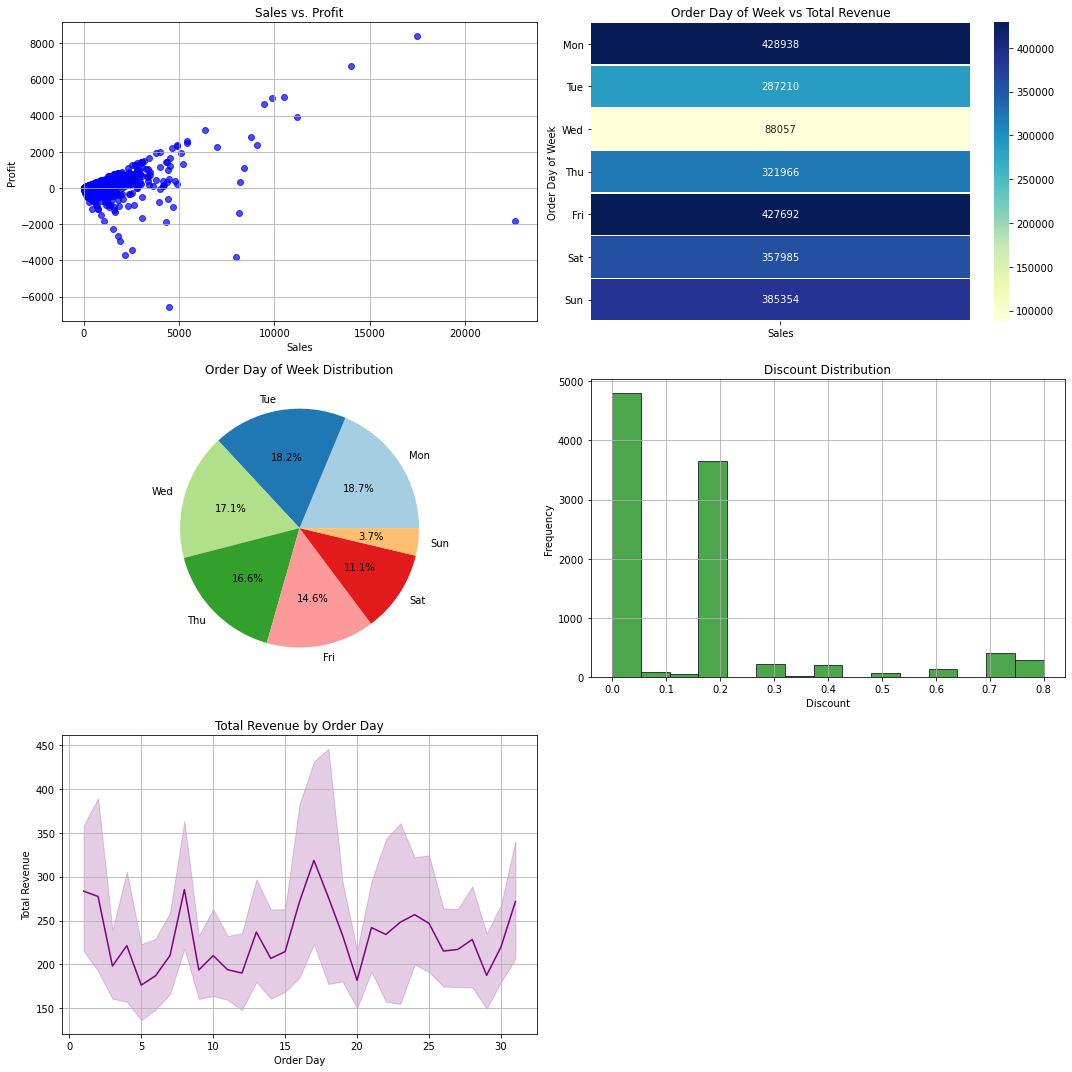

In [21]:
# Create subplots with 2 plots in each row
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

# Sales vs. Profit Scatter Plot
axes[0, 0].scatter(df_customer_transaction_info['Sales'], df_customer_transaction_info['Profit'], color='blue', alpha=0.7)
axes[0, 0].set_xlabel('Sales')
axes[0, 0].set_ylabel('Profit')
axes[0, 0].set_title('Sales vs. Profit')
axes[0, 0].grid(True)

# Order Day of Week vs Total Revenue Heatmap
order_day_of_week_pivot = df_customer_transaction_info.pivot_table(index='Order Day of Week', values='Sales', aggfunc='sum')
sns.heatmap(order_day_of_week_pivot, cmap='YlGnBu', annot=True, fmt='.0f', linewidths=0.5, ax=axes[0, 1])
axes[0, 1].set_title('Order Day of Week vs Total Revenue')
axes[0, 1].set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)

# Order Day of Week Pie Chart
order_day_of_week_counts = df_customer_transaction_info['Order Day of Week'].value_counts()
axes[1, 0].pie(order_day_of_week_counts, labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], autopct='%1.1f%%', colors=plt.cm.Paired.colors)
axes[1, 0].set_title('Order Day of Week Distribution')

# Discount Distribution Histogram
axes[1, 1].hist(df_customer_transaction_info['Discount'], bins=15, color='green', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Discount')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Discount Distribution')
axes[1, 1].grid(True)

# Line Plot for Order Day vs Total Revenue
sns.lineplot(data=df_customer_transaction_info, x='Order Day', y='Sales', color='purple', ax=axes[2, 0])
axes[2, 0].set_xlabel('Order Day')
axes[2, 0].set_ylabel('Total Revenue')
axes[2, 0].set_title('Total Revenue by Order Day')
axes[2, 0].grid(True)

# Remove empty plot
fig.delaxes(axes[2, 1])

# Adjust layout
plt.tight_layout()

# Show the subplots
plt.show()


**1. Highest number of orders are placed on Monday, Tuesday and least orders on Sunday**   
**2. Highest revenue is generated on Monday and Wednesday**   
**3. Highest revenue are generated at 17th day of month followed by peaks at start, end of month**  
**4. In most of orders no discounts were given, followed by 0.2% discount**  

In [22]:
# Function to read JSON data from a file and return a DataFrame
def read_json_to_dataframe(file_name):
    file_path = os.path.join(bmc_data_path, file_name)
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            json_data = json.load(file)
            if isinstance(json_data, list):
                # Assuming the JSON file is a list of dictionaries
                df = pd.DataFrame(json_data)
            elif isinstance(json_data, dict) and 'data' in json_data and 'columns' in json_data:
                # Assuming the JSON file can be directly converted to a DataFrame using pandas
                df = pd.DataFrame(json_data['data'], columns=json_data['columns'])
            elif isinstance(json_data, dict) and all(key.isdigit() for key in json_data.keys()):
                # Assuming the JSON file is a dictionary with integer keys
                df = pd.DataFrame([json_data[key] for key in json_data], index=json_data.keys())
            elif isinstance(json_data, dict) and all(key.isdigit() for key in json_data.keys()):
                # Assuming the JSON file has keys representing row indices
                df = pd.DataFrame([json_data[str(key)] for key in range(len(json_data))])
            else:
                print(f"Unknown JSON format in {file_name}")
                df = None
            return df
    except Exception as e:
        print(f"Error loading JSON data from {file_name}: {e}")
        return None

# Function to print truncated JSON
def print_truncated_json(json_data, max_lines=20):
    truncated_data = json.dumps(json_data, indent=2)[:max_lines*2]
    if len(json_data) > max_lines:
        truncated_data += "\n..."
    print(truncated_data)

# Read the files and convert them to DataFrames

# Read the 'customers_info.json' file
df_customers_info = read_json_to_dataframe('customers_info.json')

# Read the 'orders_returned_info.json' file
df_orders_returned_info = read_json_to_dataframe('orders_returned_info.json')

# Read the 'region_seller_info.json' file
df_region_seller_info = read_json_to_dataframe('region_seller_info.json')

# Print the first few rows of each DataFrame
print("DataFrame for customers_info.json:")
if df_customers_info is not None:
    print(df_customers_info.head())

print("\nDataFrame for orders_returned_info.json:")
if df_orders_returned_info is not None:
    print(df_orders_returned_info.head())

print("\nDataFrame for region_seller_info.json:")
if df_region_seller_info is not None:
    print(df_region_seller_info.head())

DataFrame for customers_info.json:
  Customer ID    Customer Name    Segment        Country             City  \
0    CG-12520      Claire Gute   Consumer  United States        Henderson   
1    DV-13045  Darrin Van Huff  Corporate  United States      Los Angeles   
2    SO-20335   Sean O'Donnell   Consumer  United States  Fort Lauderdale   
3    BH-11710  Brosina Hoffman   Consumer  United States      Los Angeles   
4    AA-10480     Andrew Allen   Consumer  United States          Concord   

            State  Postal Code Region  
0        Kentucky        42420  South  
1      California        90036   West  
2         Florida        33311  South  
3      California        90032   West  
4  North Carolina        28027  South  

DataFrame for orders_returned_info.json:
  Returned        Order ID
0      Yes  CA-2017-153822
1      Yes  CA-2017-129707
2      Yes  CA-2014-152345
3      Yes  CA-2015-156440
4      Yes  US-2017-155999

DataFrame for region_seller_info.json:
                  

## customer_info:

In [23]:
df_customers_info.head()

,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region
0,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South
1,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West
2,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South
3,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West
4,AA-10480,Andrew Allen,Consumer,United States,Concord,North Carolina,28027,South


In [24]:
df_customers_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4910 entries, 0 to 4909
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Customer ID    4910 non-null   object
 1   Customer Name  4910 non-null   object
 2   Segment        4910 non-null   object
 3   Country        4910 non-null   object
 4   City           4910 non-null   object
 5   State          4910 non-null   object
 6   Postal Code    4910 non-null   int64 
 7   Region         4910 non-null   object
dtypes: int64(1), object(7)
memory usage: 307.0+ KB


In [25]:
df_customers_info.nunique()

Customer ID      793
Customer Name    793
Segment            3
Country            1
City             531
State             49
Postal Code      631
Region             4
dtype: int64

In [26]:
df_customers_info.shape

(4910, 8)

In [27]:
df_customers_info[df_customers_info['Customer ID']=='CG-12520']

,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region
0,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South
2704,CG-12520,Claire Gute,Consumer,United States,Houston,Texas,77070,Central
3359,CG-12520,Claire Gute,Consumer,United States,Dallas,Texas,75217,Central


**The customers have multiple entry in the table**

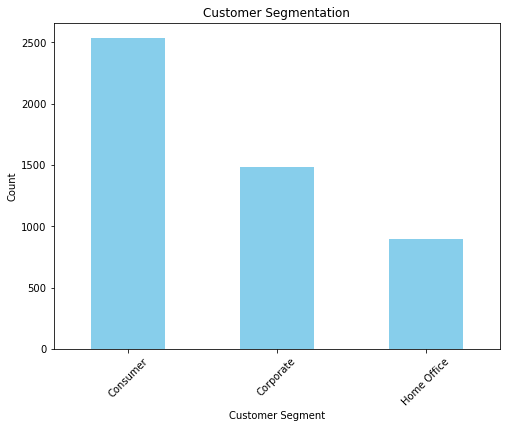

In [28]:
# Bar plot for customer segments
plt.figure(figsize=(8, 6))
df_customers_info['Segment'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Customer Segment')
plt.ylabel('Count')
plt.title('Customer Segmentation')
plt.xticks(rotation=45)
plt.show()


**Highest count of customers are from Consumer segments**

### Dropping the features as we want unique values of customers:

In [29]:
# Drop the specified columns from the DataFrame
df_customers_info.drop(['City', 'State', 'Postal Code', 'Region'], axis=1, inplace=True)

In [30]:
# Get unique customer data based on 'Customer ID'
df_customers_info = df_customers_info.drop_duplicates(subset='Customer ID')

In [31]:
df_customers_info.shape

(793, 4)

In [32]:
df_customers_info.head()

,Customer ID,Customer Name,Segment,Country
0,CG-12520,Claire Gute,Consumer,United States
1,DV-13045,Darrin Van Huff,Corporate,United States
2,SO-20335,Sean O'Donnell,Consumer,United States
3,BH-11710,Brosina Hoffman,Consumer,United States
4,AA-10480,Andrew Allen,Consumer,United States


## df_orders_returned_info:

In [33]:
df_orders_returned_info.head()

,Returned,Order ID
0,Yes,CA-2017-153822
1,Yes,CA-2017-129707
2,Yes,CA-2014-152345
3,Yes,CA-2015-156440
4,Yes,US-2017-155999


In [34]:
df_orders_returned_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296 entries, 0 to 295
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Returned  296 non-null    object
 1   Order ID  296 non-null    object
dtypes: object(2)
memory usage: 6.9+ KB


In [35]:
df_orders_returned_info.nunique()

Returned      1
Order ID    296
dtype: int64

In [36]:
df_orders_returned_info['Returned'].value_counts()

Yes    296
Name: Returned, dtype: int64

**All the orders present in this table were returned**

## df_region_seller_info:

In [37]:
df_region_seller_info.head()

,0,1,2,3
0,Anna Andreadi,West,Femail,45
1,Chuck Magee,East,G,43
2,Kelly Williams,Central,None,35
3,Cassandra Brandow,South,F,9849


**We will not be using this dataframe as we dont have any join column**

## Data Preparation:

In [38]:
# Step 1: Merge df_customer_transaction_info with df_product_info
merged_step1 = pd.merge(df_customer_transaction_info, df_product_info, on="Product ID", how="left")

# Step 2: Merge the result with df_customers_info
merged_dataframe = pd.merge(merged_step1, df_customers_info, on="Customer ID", how="left")

In [39]:
# Print the final merged DataFrame
merged_dataframe.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Product ID,Sales,Quantity,Discount,Profit,Total Revenue,Average Profit per Unit,Order Year,Order Month,Order Day,Order Day of Week,Order to Ship Duration,Category,Sub-Category,Product Name,printer_related,Customer Name,Segment,Country
0,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,FUR-BO-10001798,261.9600,2,0.00,41.9136,523.9200,20.9568,2016,11,8,1,3,Furniture,Bookcases,Bush Somerset Collection Bookcase,False,Claire Gute,Consumer,United States
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,FUR-CH-10000454,731.9400,3,0.00,219.5820,2195.8200,73.1940,2016,11,8,1,3,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",False,Claire Gute,Consumer,United States
2,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,OFF-LA-10000240,14.6200,2,0.00,6.8714,29.2400,3.4357,2016,6,12,6,4,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,False,Darrin Van Huff,Corporate,United States
3,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,FUR-TA-10000577,957.5775,5,0.45,-383.0310,4787.8875,-76.6062,2015,10,11,6,7,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,False,Sean O'Donnell,Consumer,United States
4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,OFF-ST-10000760,22.3680,2,0.20,2.5164,44.7360,1.2582,2015,10,11,6,7,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,False,Sean O'Donnell,Consumer,United States


In [40]:
merged_dataframe.shape

(10331, 24)

### Dropping the orders which were returned:

In [41]:
# Convert 'Returned' column in df_orders_returned_info to boolean
df_orders_returned_info['Returned'] = df_orders_returned_info['Returned'] == 'Yes'

# Remove the returned orders from the main DataFrame
merged_dataframe = merged_dataframe.merge(df_orders_returned_info, how='left', on='Order ID', indicator=True)
merged_dataframe = merged_dataframe[merged_dataframe['_merge'] == 'left_only']

# Drop the 'Returned' and '_merge' columns, if needed
merged_dataframe.drop(['Returned', '_merge'], axis=1, inplace=True)

In [42]:
merged_dataframe.shape

(9500, 24)

In [43]:
merged_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9500 entries, 0 to 10330
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Order ID                 9500 non-null   object        
 1   Order Date               9500 non-null   datetime64[ns]
 2   Ship Date                9500 non-null   datetime64[ns]
 3   Ship Mode                9500 non-null   object        
 4   Customer ID              9500 non-null   object        
 5   Product ID               9500 non-null   object        
 6   Sales                    9500 non-null   float64       
 7   Quantity                 9500 non-null   int64         
 8   Discount                 9500 non-null   float64       
 9   Profit                   9500 non-null   float64       
 10  Total Revenue            9500 non-null   float64       
 11  Average Profit per Unit  9500 non-null   float64       
 12  Order Year               9500 non

In [44]:
merged_dataframe.columns

Index(['Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID',
       'Product ID', 'Sales', 'Quantity', 'Discount', 'Profit',
       'Total Revenue', 'Average Profit per Unit', 'Order Year', 'Order Month',
       'Order Day', 'Order Day of Week', 'Order to Ship Duration', 'Category',
       'Sub-Category', 'Product Name', 'printer_related', 'Customer Name',
       'Segment', 'Country'],
      dtype='object')

# STEP 4: Modeling:

## Model Building & Evaluation:

In [45]:
%%time 
# Drop unnecessary columns
merged_dataframe.drop(['Order ID', 'Order Date', 'Ship Date', 'Product ID'], axis=1, inplace=True)

# Encode categorical columns
encoder = LabelEncoder()
for col in merged_dataframe.select_dtypes(include='object'):
    merged_dataframe[col] = encoder.fit_transform(merged_dataframe[col])

# Separate features (X) and target (y)
X = merged_dataframe.drop('printer_related', axis=1)
y = merged_dataframe['printer_related']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 1: Resample the data using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Step 2: Perform hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf_model = RandomForestClassifier(random_state=42)

grid_search = RandomizedSearchCV(rf_model, param_grid, scoring='recall', cv=5)
grid_search.fit(X_resampled, y_resampled)

# Best hyperparameters from grid search
best_params = grid_search.best_params_

# Train the model with best hyperparameters
best_rf_model = RandomForestClassifier(random_state=42, **best_params)
best_rf_model.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Calculate accuracy and recall
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
print("Recall:", recall)

# Classification Report and Confusion Matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Best Hyperparameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 5}
Accuracy: 0.9950877192982456
Recall: 0.9545454545454546
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2828
        True       0.62      0.95      0.75        22

    accuracy                           1.00      2850
   macro avg       0.81      0.97      0.87      2850
weighted avg       1.00      1.00      1.00      2850

Confusion Matrix:
[[2815   13]
 [   1   21]]
Wall time: 2min 15s


# STEP 5: Model Evaluation:

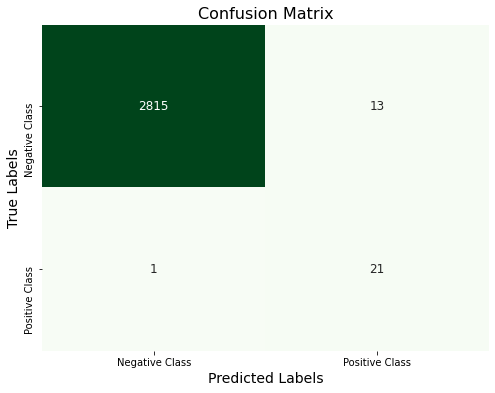

In [46]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define labels for the binary confusion matrix
labels = ['Negative Class', 'Positive Class']

# Create a DataFrame from the confusion matrix and labels
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot the confusion matrix using seaborn heatmap with 'YlGnBu' color map
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Greens', cbar=False, annot_kws={'size': 12})
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

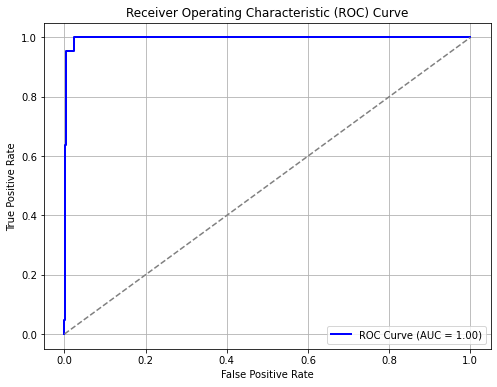

In [48]:
# Get the predicted probabilities for the positive class
y_prob = best_rf_model.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_prob)))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

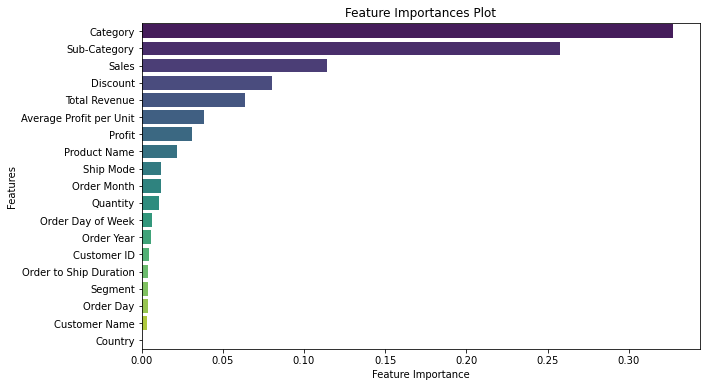

In [49]:
# Get feature importances from the trained model
importances = best_rf_model.feature_importances_

# Create a DataFrame to store feature importances
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the features by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df, palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances Plot')
plt.show()

# STEP 6: DEPLOYMENT

## Save the trained model for future inference:

In [51]:
# Save the trained model as a pickle file
with open('best_rf_model.pkl', 'wb') as file:
    pickle.dump(best_rf_model, file)

**To deploy the model, the following steps can be taken:** 
  
**6.1 Data Preprocessing:** Make sure the input data is preprocessed in the same way as during model training. This may include handling missing values, encoding categorical variables, and scaling numerical features.
  
**6.2 Model Serialization:** Serialize the trained ML model into a format that can be easily saved and loaded. Common formats include pickle or joblib. This is already done here.
  
**6.3 Create an API:** Develop an API that exposes the model's prediction functionality. This API should receive input data from the Marketing department and return the predictions.
  
**6.4 Set up a Web Service:** Deploy the API as a web service on a server or cloud platform that can handle incoming requests from the Marketing team.
  
**6.5 Security and Authentication:** Implement security measures to ensure that only authorized users can access the model's predictions.  

**6.6 Monitoring:** Monitor the model's performance in production to identify any potential issues or changes in the data distribution.  

## Analysis Summary

Based on the provided dataset, a predictive model has been built to predict the probability that a given customer will buy a "printer-related product."

### Model Performance Metrics

- **Accuracy**: 99.51%
- **Recall**: 95.45%

The model shows high accuracy for the majority class (False), but relatively lower precision for the minority class (True). The recall is decent for the minority class, indicating that the model is able to identify a good portion of customers who may buy a "printer-related product."

### Classification Report

The classification report provides precision, recall, and F1-score for each class (False and True).

```python
              precision    recall  f1-score   support
       False       1.00      1.00      1.00      2828
        True       0.62      0.95      0.75        22
```

### Feature Importance  
The feature importance analysis reveals the significance of each feature in predicting whether a customer will buy a "printer-related product." The top five most important features, in descending order of importance, are:  
  
Category  
Sub-Category  
Sales  
Discount  
Total Revenue  